<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/NataPereUnit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is like a flowchart that helps make decisions by asking a series of yes/no questions. Each question splits the data into smaller groups based on certain features (like size or color). The tree keeps splitting until it reaches an answer or prediction. It's easy to understand because it looks like a tree, where the root is the starting point, branches are decisions, and leaves are the final outcomes.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many levels or splits it has from the starting point to the final decision. If the tree is too deep, it might overfit the data, meaning it’s too good at memorizing the training data but not good at predicting new data. If it’s not deep enough, it might miss important patterns and be too simple, leading to underfitting. The right depth balances capturing patterns without overfitting or underfitting.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are like decision trees but better? a decision tree is just one tree making predictions, BART combines many decision trees to improve accuracy. BART also uses special math (Bayesian methods) to give better and more reliable predictions, while a decision tree just gives a single answer. THUS, BART is more powerful and less likely to overfit than a single decision tre

**Task5**:

Why would we use a BART model instead of a decision tree?

We'd use a BART model instead of a decision tree because BART combines many trees, making it more accurate and less likely to overfit.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree

In [4]:
!pip install pymc-bart
!pip install preliz

  Using cached preliz-0.16.0-py3-none-any.whl.metadata (6.1 kB)
Using cached preliz-0.16.0-py3-none-any.whl (519 kB)


In [5]:
import pymc_bart as pmb
import preliz as pz

In [6]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [7]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [8]:
X = penguins[['flipper_length', 'bill_depth', 'bill_length']].to_numpy()
Y = penguins['body_mass'].to_numpy()

In [9]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

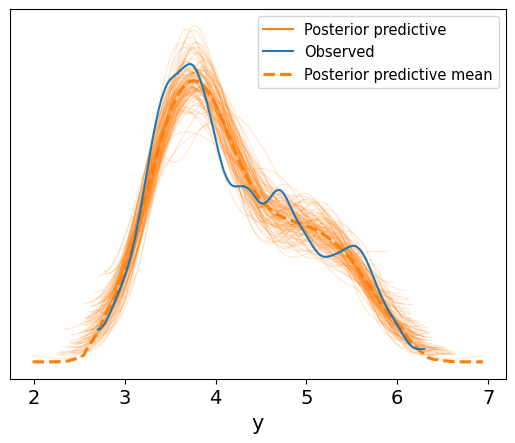

In [10]:
pm.sample_posterior_predictive(idata_penguin, model_penguin, extend_inferencedata=True)
az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [11]:

posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


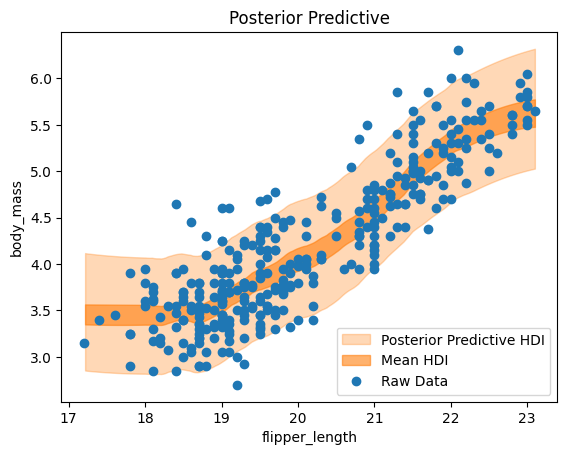

In [12]:

idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

the frapgh does a good job at representing the relationship between flipper legth and body mas! The model reflects the flat trend at both the low and high ends of flipper length, as well as the generally linear increase in the middle. THE only major issue being that some of the plot points fall outside of the the posterior predictive HDI region

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

<Axes: ylabel='R²'>

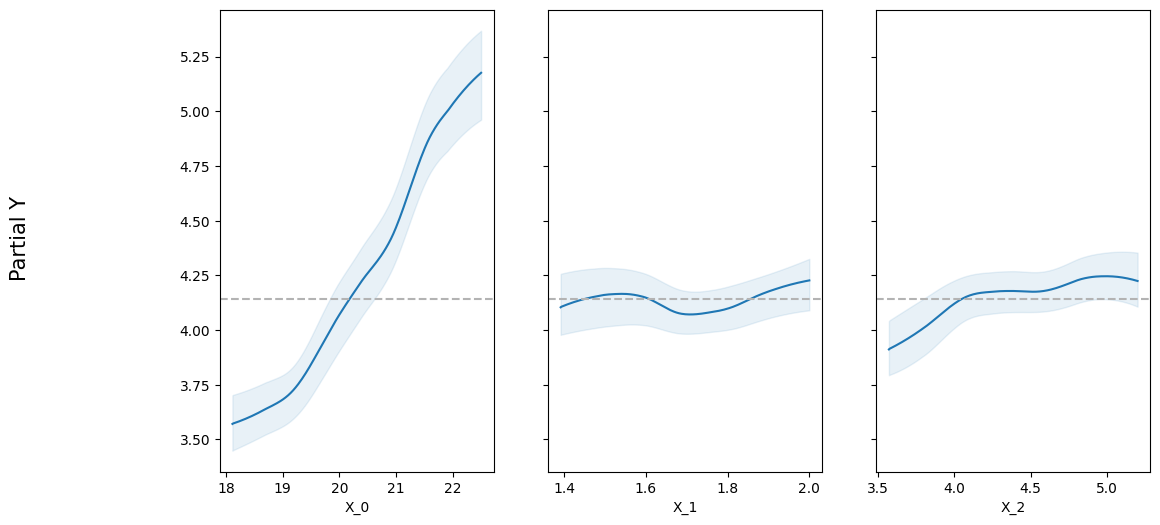

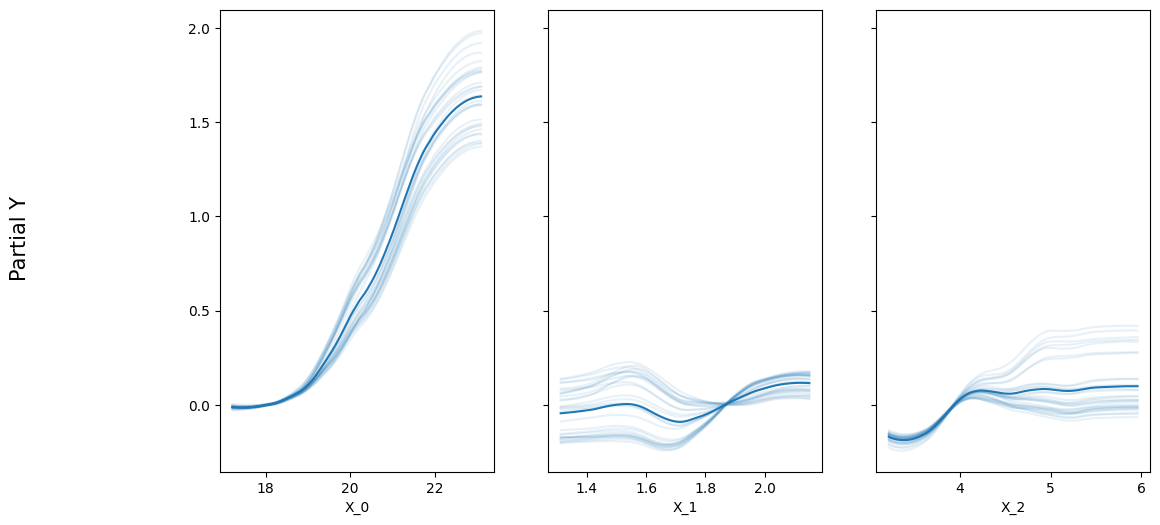

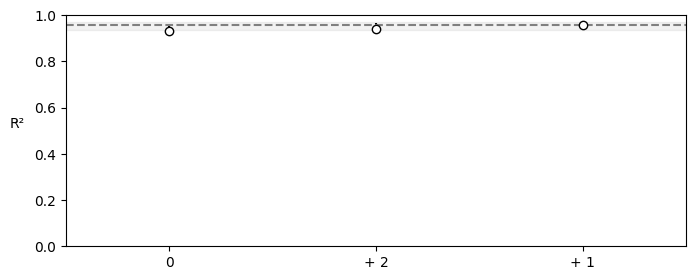

In [13]:

pmb.plot_pdp(μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))
#X_0 is flipper_length, X_1 is bill_depth, X_2 is bill_length

pmb.plot_ice( μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))
#X_0 is flipper_length, X_1 is bill_depth, X_2 is bill_length

vi_penguins = pmb.compute_variable_importance(idata_penguin, μ_, X)
pmb.plot_variable_importance(vi_penguins)
#0 is flipper_length, +1 is bill_depth, +2 is bill_length

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Looking at the PDP, we observe a strong positive linear relationship between the two. The ICE plot reveals more specific trends that aren't visible in the PDP average. For flipper length and body mass, the ICE plot shows that at lower flipper lengths, the relationship is flat, stable, and highly predictable. For flipper length and body mass, the ICE plot shows that at lower flipper lengths, the relationship is flat, stable, and highly predictable, while at higher flipper lengths, the trend remains positive but becomes more variable. For bill depth the PDP indicates a weaker positive trend with a slight dip in the middle, which is somewhat unexpected, so the ICE plots might offer more clarity. The ICE plots present an interesting picture: there's significant variation in the data before a bill depth of about 1.9, with some lines showing an increasing-then-decreasing trend and others showing the opposite. The PDP for bill length shows a positive trend that gradually flattens out. In the ICE plots, the lines are stable and tight at lower bill lengths, but at higher bill lengths, there's more variation in the predicted body mass, although the lines still flatten eventually. This variable is also valuable, as indicated by the high R² value.
That being said; all three variables are important, particularly flipper length due to its strong and stable association.
